<a href="https://colab.research.google.com/github/PENNET-dev/hackathon-uW-2024/blob/main/2024_uW_Hackathon_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2024 Hackathon - The Tone Rangers

Audio is a primary part of the human/computer interaction requried for Oral Bible Translation (OBT).  And some Bible translation efforts target "low resource languages".  As such, Bible translation software must understand spoken audio from low resource languages.

Here, we propose a model to recognize individual words in Dholuo.

Here, "low resource languages" is understood as any language that does not have open, available models for LLM, speech-to-text, and text-to-speech.

By requiring a "stable" model, we require the solution to be independent of tone, volume, speed, or the speaker's gender.

Thesis:
Find a stable method for recognizing individual words in low-resource languages.

# Literature Review:

## How Multilingual is Multilingual LLM?
https://openreview.net/pdf?id=VXNYBh_iGcfX


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install the Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import scipy.fft
import scipy.fftpack as fft
from scipy.fftpack import dct
from scipy.signal import spectrogram
import librosa
import librosa.display
import IPython.display

import os

# MFCC Walkthrough

Define the Plot functions

In [ ]:
def plot_time(audio, figsize=(5,3), title=''):
    plt.figure(figsize=figsize)
    plt.plot(audio, alpha=0.5, label='audio')
    plt.grid(True)
    plt.title(title+' Sample - Time Domain')
    plt.xlabel('time')
    plt.ylabel('amplitude')
    plt.show();

In [ ]:
def fft(data, sample_rate, figsize=(15,4),title = ''):

    N = sample_rate
    # Compute FFT
    yf = scipy.fftpack.fft(data)
    print("yf", data.shape, yf.shape)

    # Generate frequency bins
    xf = np.linspace(0.0, sample_rate//2, N//2)
    print("xf", xf.shape)

    # Find the index of the maximum amplitude and its corresponding frequency
    start_bin = int(20 * (N // 2) / (N // 2))  # Corresponding bin for 20 Hz
    max_amplitude_idx = np.argmax(2.0/N * np.abs(yf[start_bin:N//2]))
    max_amplitude_frequency = xf[start_bin:][max_amplitude_idx]

    # Plot FFT (skipping the first 20 bins to start from 20 Hz)
    plt.figure(figsize=figsize)
    start_bin = int(20 * (N // 2) / (N // 2))  # Corresponding bin for 20 Hz
    print (xf[start_bin:].shape, yf[start_bin:N//2].shape)
    plt.semilogx(xf[start_bin:], 2.0/N * np.abs(yf[start_bin:N//2]))

    # Add a point and label for the frequency with the maximum amplitude
    plt.scatter(max_amplitude_frequency, 2.0/N * np.abs(yf[start_bin:][max_amplitude_idx]), color='red')
    plt.annotate(f'Max Amp. @ {max_amplitude_frequency:.2f} Hz',
                 (max_amplitude_frequency, 2.0/N * np.abs(yf[start_bin:][max_amplitude_idx])),
                 textcoords="offset points",
                 xytext=(10,-10),
                 ha='left')

   # plt.semilogx(2.0/N * np.abs(yf[20:N//2]))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('amp')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    plt.show();
    return yf, max_amplitude_frequency


In [ ]:
def plot_spectogram(audio, sample_rate, figsize=(10,5), title=''):
    epsilon = 1e-10 # Small constant to avoid log10(0)
    frequencies, times, Sxx = spectrogram(audio, sample_rate)
    plt.figure(figsize=figsize)
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx + epsilon), shading='gouraud')
    plt.title(title+' Sample - Spectogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

In [ ]:
def calc_plot_mfcc (audio, sample_rate, n_mfcc=13, figsize=(10,5), title=''):

    # Calculate MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

    # # Plotting the MFCCs
    plt.figure(figsize=figsize)
    librosa.display.specshow(mfccs,
                             x_axis='time',
                             sr=sample_rate,
                             cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel('MFCC')
    plt.xlabel('time')
    plt.ylabel('MFCC Coefficients')
    plt.yticks(np.arange(0, 13, 1), [str(i+1) for i in range(13)])
    plt.title(title +' - Mel-frequency cepstral coefficients (MFCC)')
    plt.tight_layout()
    plt.show()

Analizyng Audio raw sample

In [ ]:
# Load audio file
def load_audio(audioSampleFilePath): #, sr=64000, duration=0.13):
    assert os.path.isfile(audioSampleFilePath), f"No file at {audioSampleFilePath}"
    print(os.path.getsize(audioSampleFilePath))
    data, sample_rate = librosa.load(audioSampleFilePath)
    print(data.shape, sample_rate)
    return data, sample_rate

# Audio sample
audioFilePath_yes = "/content/InTheBeginning01.wav"
yes, sample_rate = load_audio(audioFilePath_yes)

print(yes.shape, sample_rate)


185800
(32000,) 22050
(32000,) 22050


In [ ]:
# ZPP: Philip, is this correct?  I made some changes to fft()

def fft(data, sample_rate, figsize=(15,4), title=''):
    N = len(data)
    yf = scipy.fftpack.fft(data)
    xf = np.linspace(0.0, sample_rate//2, N//2)
    max_amplitude_idx = np.argmax(2.0/N * np.abs(yf[:N//2]))
    max_amplitude_frequency = xf[max_amplitude_idx]

    plt.figure(figsize=figsize)
    plt.semilogx(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.scatter(max_amplitude_frequency, 2.0/N * np.abs(yf[:N//2][max_amplitude_idx]), color='red')
    plt.annotate(f'Max Amp. @ {max_amplitude_frequency:.2f} Hz',
                 (max_amplitude_frequency, 2.0/N * np.abs(yf[:N//2][max_amplitude_idx])),
                 textcoords="offset points", xytext=(10,-10), ha='left')

    plt.xlabel('frequency [Hz]')
    plt.ylabel('amp')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    plt.show()

    return yf, max_amplitude_frequency

Plot the FFT

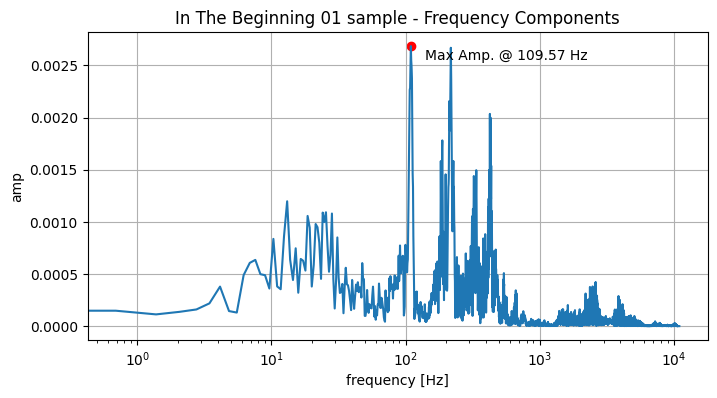

fft [-0.604509-0.j         -0.985419-2.1503694j   1.798337+0.06873521j ...
 -1.897502-1.1024456j   1.798337-0.06873521j -0.985419+2.1503694j ] 109.56778548659291


In [ ]:
yf_yes, max_amp_freq_yes = fft(yes, sample_rate, figsize = (8,4), title = 'In The Beginning 01')

print("fft", yf_yes, max_amp_freq_yes)

Plot Spectogram

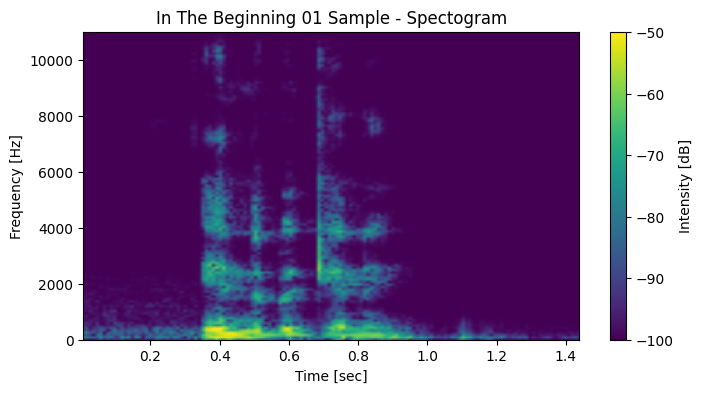

In [ ]:
plot_spectogram(yes, sample_rate, figsize = (8,4), title='In The Beginning 01')

MFCC Plot with Librosa

Librosa function is designed to handle the entire MFCC extraction process starting from the raw audio signal.

When you pass the raw audio signal to librosa.feature.mfcc, the function internally performs several steps including:

Framing the signal into overlapping frames.
Applying a window function to each frame.
Calculating the FFT to convert each frame to the frequency domain.
Applying Mel filter banks to the frequency spectra.
Taking the logarithm of the Mel frequencies.
Performing the Discrete Cosine Transform (DCT).

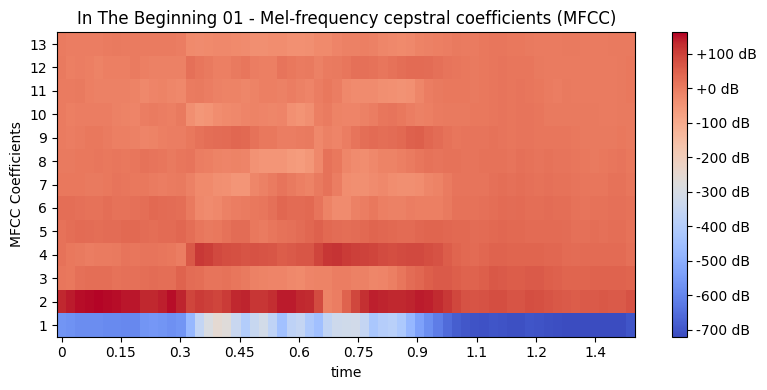

In [ ]:
calc_plot_mfcc (yes, sample_rate, n_mfcc=13, figsize = (8,4), title='In The Beginning 01')

The above plot was generated with the default Librosa MFCC package parameters.

Generating MFCC Features

MFCC Calculation and plot using numpy and scipy libraries

In [ ]:
audio = yes.copy()
type(audio)

numpy.ndarray

Pre-emphasis: Apply a pre-emphasis filter to high-pass filter the audio signal:

In [ ]:
alpha = 0.98 #Coefficient
audio = np.append(audio[0], audio[1:] - alpha * audio[:-1])

Framing: Split the signal using frame lenght of 25 milliseconds with a Frame stride of 20 milliseconds:

In [ ]:
# Parameters
frame_size = 0.025  # frame size in seconds
frame_stride = 0.020  # frame stride in seconds

# Calculate frame length and frame step (convert from seconds to samples)
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))

# Calculate the total number of frames
num_frames = int(np.ceil(float(np.abs(len(audio) - frame_length)) / frame_step))

frame_length, frame_step, num_frames

(551, 441, 72)

In [ ]:
# Pad audio signal
pad_audio_length = num_frames * frame_step + frame_length
z = np.zeros((pad_audio_length - len(audio)))
pad_audio = np.append(audio, z)

In [ ]:
pad_audio.shape

(32303,)

In [ ]:
# Initialize the frames
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_audio[indices.astype(np.int32, copy=False)]

In [ ]:
frames.shape

(72, 551)

Windowing: Apply a Hamming window to each frame:

In [ ]:
# Apply window function (Hamming)
frames *= np.hamming(frame_length)
frames[0].shape

(551,)

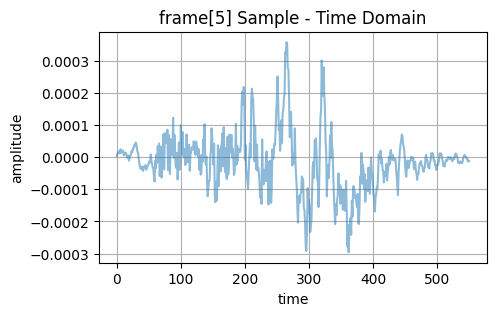

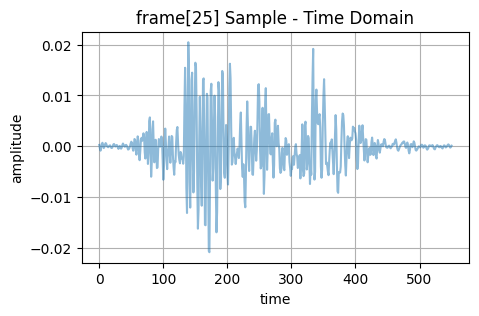

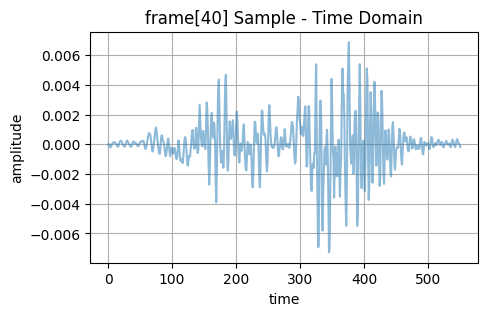

In [ ]:
plot_time(frames[5], figsize = (5,3), title='frame[5]')
plot_time(frames[25], figsize = (5,3), title='frame[25]')
plot_time(frames[40], figsize = (5,3), title='frame[40]')

Fast Fourier Transform (FFT): Perform FFT to convert the frames to frequency domain:

In [ ]:
# Perform FFT and calculate power spectrum
NFFT = 512 # FFT lenght
mag_frames = np.absolute(np.fft.fft(frames, NFFT))
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

In [ ]:
mag_frames = mag_frames[:, :NFFT//2 + 1]
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

In [ ]:
mag_frames.shape, pow_frames.shape

((72, 257), (72, 257))

In [ ]:
def plot_frame_fft(data, figsize=(5,3), title=''):
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.xlabel('FFT Lenght')
    plt.ylabel('power')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    plt.show();

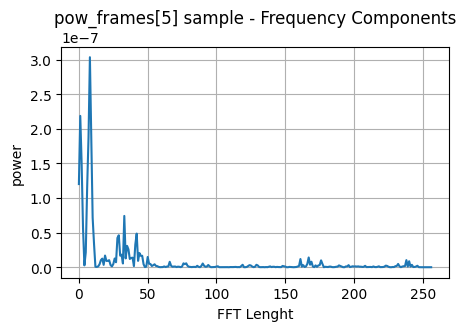

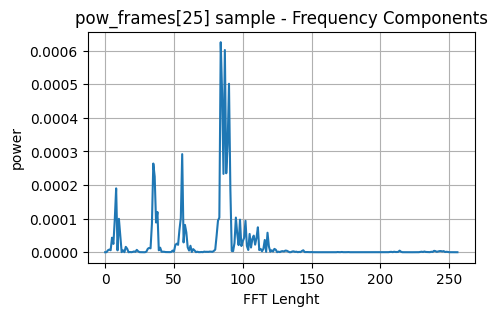

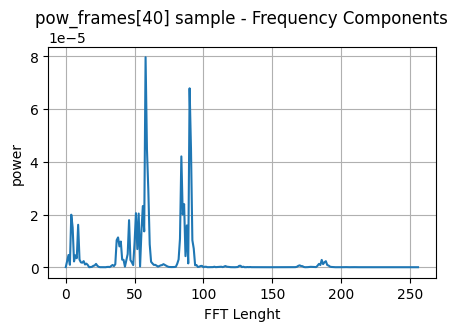

In [ ]:
plot_frame_fft(pow_frames[5], title = 'pow_frames[5]')
plot_frame_fft(pow_frames[25], title = 'pow_frames[25]')
plot_frame_fft(pow_frames[40], title = 'pow_frames[40]')

Mel Filter Banks: The frequency domain is then mapped to the Mel scale, which approximates the response of the human ear to different frequencies.

By setting low_freq_mel to the Mel equivalent of low_freq_cut (for ex. 80 Hz), we ensure that the lowest band edge of your Mel filter bank starts at that freq.

In [ ]:
low_freq_cut = -100
low_freq_mel = 2595 * np.log10(1 + low_freq_cut / 700.0)  # Convert Hz to Mel

In [ ]:
# Apply Mel filter banks
nfilt = 32
#low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])
    f_m = int(bin[m])
    f_m_plus = int(bin[m + 1])

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = 1 - (k - bin[m]) / (bin[m + 1] - bin[m])

filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)  # dB

In [ ]:
filter_banks.shape

(72, 32)

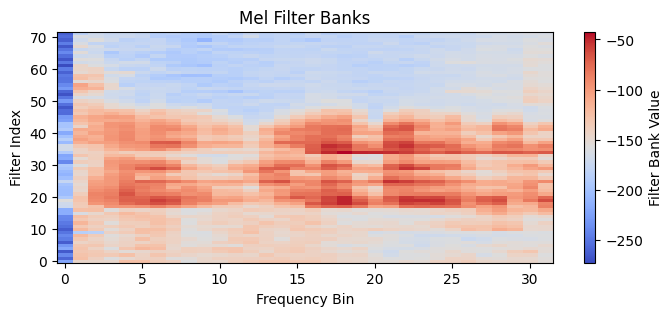

In [ ]:
# Plotting the filter bank matrix
plt.figure(figsize=(8,3))
plt.imshow(filter_banks, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Filter Bank Value')
plt.xlabel('Frequency Bin')
plt.ylabel('Filter Index')
plt.title('Mel Filter Banks')
plt.show()

Normalization:

In [ ]:
noise_floor_dB = -100  # Replace with your specific noise floor level in dB

# Apply the noise floor
filter_banks = np.where(filter_banks < noise_floor_dB, noise_floor_dB, filter_banks)

# Optional: Normalize the Mel Filterbank Energies
mean = np.mean(filter_banks, axis=0)
std_dev = np.std(filter_banks, axis=0)
std_dev[std_dev == 0] = 1e-10

filter_banks -= mean
filter_banks /= std_dev

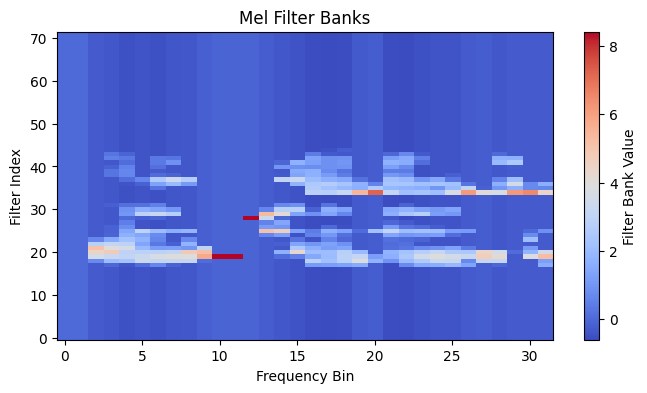

In [ ]:
# Plotting the filter bank matrix
plt.figure(figsize=(8,4))
plt.imshow(filter_banks, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Filter Bank Value')
plt.xlabel('Frequency Bin')
plt.ylabel('Filter Index')
plt.title('Mel Filter Banks')
plt.show()

Discrete Cosine Transform (DCT): The Mel frequencies are decorrelated and compressed, resulting in the final set of MFCCs.

In [ ]:
# Apply Discrete Cosine Transform (DCT)
num_ceps = 13
mfcc = dct(filter_banks, type=2, axis=-1, norm='ortho')[:, 1 : (num_ceps + 1)]  # Exclude 0th order coefficient (energy)

In [ ]:
mfcc.shape

(72, 13)

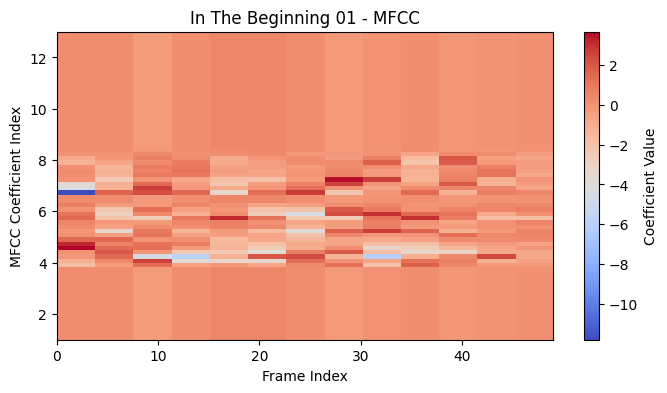

In [ ]:
# Plotting the MFCC
plt.figure(figsize=(8,4))
plt.imshow(mfcc, cmap='coolwarm', origin='lower', aspect='auto', extent=[0, 49, 1, 13])
plt.colorbar(label='Coefficient Value')
plt.xlabel('Frame Index')
plt.ylabel('MFCC Coefficient Index')
plt.title('In The Beginning 01 - MFCC')
plt.show()

# ZPP: Philip, this plot looks blank when I run it
# Can you explain what we expect to see?  what does it mean?

Flatten the array to create a list of processed features

In [ ]:
processed_features = mfcc.flatten()
processed_features = np.round(processed_features, 4)
processed_features = processed_features.tolist()
len(processed_features)

936

In [ ]:
processed_features[:10]

[0.254,
 0.2812,
 -0.2623,
 0.1869,
 0.4131,
 0.4313,
 0.2361,
 -0.1881,
 0.0724,
 0.1867]

# Wrapped in a single function

Using a function to calc, save and plot mfcc features.

This function describes the above process into one function "calc_plot_mfcc_features"

In [ ]:
def calc_plot_mfcc_features(audio,
                             sample_rate,
                             alpha = 0.97,
                             NFFT=512,
                             low_freq_cut=10,
                             nfilt=40,
                             noise_floor_dB=-100,
                             frame_size=0.02,
                             frame_stride=0.02,
                             num_ceps=13,
                             figsize=(10, 5),
                             title= 'In The Beginning 01'
                             ):

    # Pre-emphasis
    audio = np.append(audio[0], audio[1:] - alpha * audio[:-1])

    # Calculate frame length and frame step (convert from seconds to samples)
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Calculate the total number of frames
    num_frames = int(np.ceil(float(np.abs(len(audio) - frame_length)) / frame_step))

    # Pad audio signal
    pad_audio_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_audio_length - len(audio)))
    pad_audio = np.append(audio, z)

    # Initialize the frames
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_audio[indices.astype(np.int32, copy=False)]

    # Apply window function (Hamming)
    frames *= np.hamming(frame_length)

    # Perform FFT and calculate power spectrum
    #mag_frames = np.absolute(fft.fft(frames, NFFT))
    #pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    mag_frames = np.absolute(np.fft.fft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Take only up to (NFFT/2) + 1 elements after the FFT,
    # as those are the unique frequency components for real-valued signals.
    mag_frames = mag_frames[:, :NFFT//2 + 1]
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # By setting low_freq_mel to the Mel equivalent of low_freq_cut (for ex. 80 Hz),
    # we ensure that the lowest band edge of your Mel filter bank starts at that freq.
    low_freq_mel = 2595 * np.log10(1 + low_freq_cut / 700.0)  # Convert Hz to Mel

    # Apply Mel filter banks
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = 1 - (k - bin[m]) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # dB

    # Apply the noise floor
    filter_banks = np.where(filter_banks < noise_floor_dB, noise_floor_dB, filter_banks)

    # Normalize the Mel Filterbank Energies
    mean = np.mean(filter_banks, axis=0)
    std_dev = np.std(filter_banks, axis=0)
    std_dev[std_dev == 0] = 1e-10
    filter_banks -= mean
    filter_banks /= std_dev

    # Apply Discrete Cosine Transform (DCT)
    mfcc = dct(filter_banks,
            type=2,
            axis=-1,
            norm='ortho')[:, 1 : (num_ceps + 1)]  # Exclude 0th order coefficient (energy)

    # create a list of processed features
    processed_features = mfcc.flatten()
    processed_features = np.round(processed_features, 4)
    processed_features = processed_features.tolist()

    # Plotting the filter bank matrix
    plt.figure(figsize=figsize)
    plt.imshow(filter_banks, aspect='auto', cmap='coolwarm', origin='lower')
    plt.colorbar(label='Filter Bank Value')
    plt.xlabel('Frequency Bin')
    plt.ylabel('Filter Index')
    plt.title(title+' - Mel Filter Banks')

    # Plotting the MFCC
    plt.figure(figsize=figsize)
    plt.imshow(mfcc, cmap='coolwarm', origin='lower', aspect='auto', extent=[0, 49, 1, 13])
    plt.colorbar(label='Coefficient Value')
    plt.xlabel('Frame Index')
    plt.ylabel('MFCC Coefficient Index')
    plt.title(title+' - MFCC')
    plt.show()

    return processed_features

107866
(297216,) 22050
(297216,) 22050
185800
(32000,) 22050
(32000,) 22050
286764
(35840,) 22050
(35840,) 22050


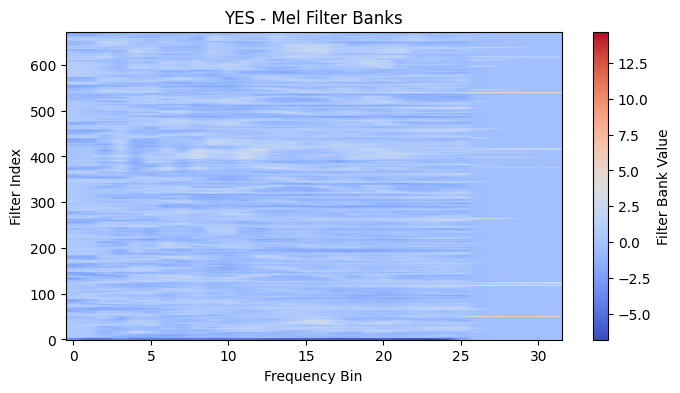

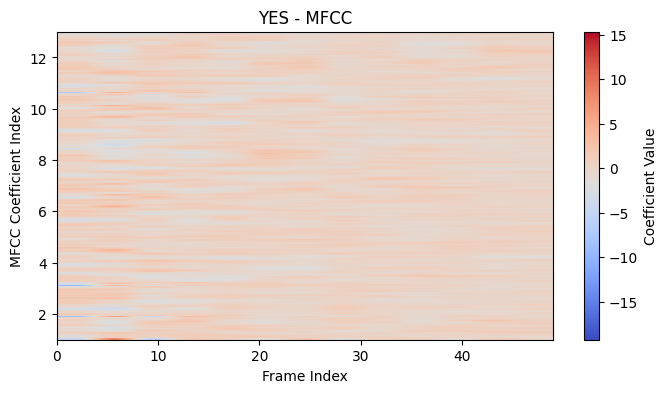

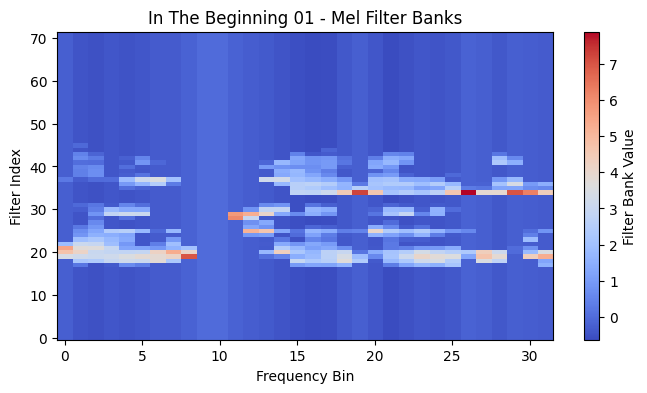

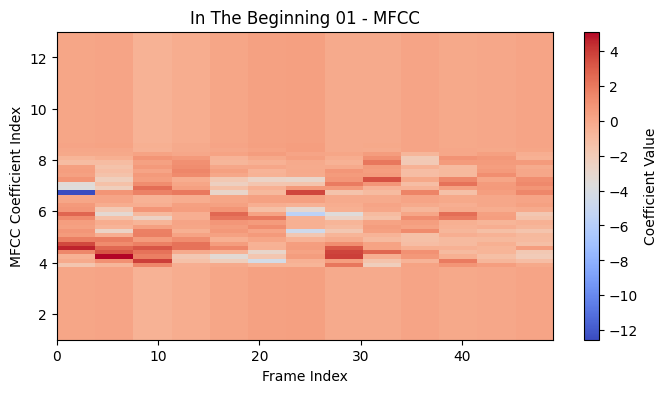

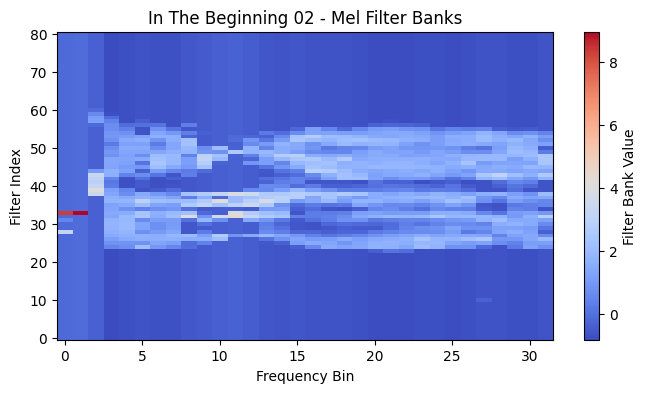

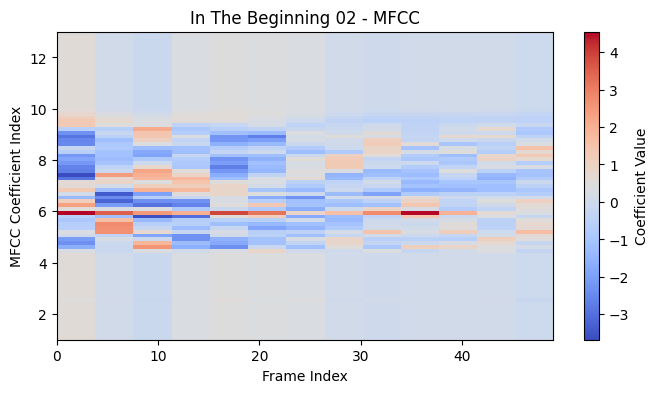

---------In The Beginning 01-----------
(297216,)
(32000,)
(35840,)
---------In The Beginning 02-----------
[-4.6231, 8.8784, -5.5334, 1.9495, 0.5843, -1.734, 2.3086, -1.7121, 0.5929, 0.5058]
[0.5363, 0.0717, -0.1012, 0.3244, 0.4332, 0.3966, 0.3158, 0.0852, -0.0091, 0.0825]


In [ ]:
# Audio sample
audioFilePath_yes = "/content/2438^yeslord.mp3"
yes, sample_rate = load_audio(audioFilePath_yes)
print(yes.shape, sample_rate)

# Audio sample
# /content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/InTheBeginning01.wav
audioFilePath_inTheBeginning01 = "/content/InTheBeginning01.wav"
inTheBeginning01, sample_rate = load_audio(audioFilePath_inTheBeginning01)
print(inTheBeginning01.shape, sample_rate)


# Audio sample
# /content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/InTheBeginning02.wav
audioFilePath_inTheBeginning02 = "/content/InTheBeginning02.wav"
inTheBeginning02, sample_rate = load_audio(audioFilePath_inTheBeginning02)
print(inTheBeginning02.shape, sample_rate)



processed_features_yes = calc_plot_mfcc_features(
                        yes,
                        sample_rate,
                        alpha = 0.97,
                        NFFT=512,
                        low_freq_cut=10,
                        nfilt=32,
                        noise_floor_dB=-100,
                        frame_size=0.025,
                        frame_stride=0.02,
                        num_ceps = 13,
                        figsize = (8,4),
                        title= 'YES'
  )


processed_features_inTheBeginning01 = calc_plot_mfcc_features(
                        inTheBeginning01,
                        sample_rate,
                        alpha = 0.97,
                        NFFT=512,
                        low_freq_cut=10,
                        nfilt=32,
                        noise_floor_dB=-100,
                        frame_size=0.025,
                        frame_stride=0.02,
                        num_ceps = 13,
                        figsize = (8,4),
                        title= 'In The Beginning 01'
  )
processed_features_inTheBeginning02 = calc_plot_mfcc_features(
                        inTheBeginning02,
                        sample_rate,
                        alpha = 0.97,
                        NFFT=512,
                        low_freq_cut=10,
                        nfilt=32,
                        noise_floor_dB=-100,
                        frame_size=0.025,
                        frame_stride=0.02,
                        num_ceps = 13,
                        figsize = (8,4),
                        title= 'In The Beginning 02'
  )

print('---------In The Beginning 01-----------')
print(yes.shape)
print(inTheBeginning01.shape)
print(inTheBeginning02.shape)

print('---------In The Beginning 02-----------')
print(processed_features_yes[:10])
# print(processed_features_inTheBeginning01[:10])
print(processed_features_inTheBeginning02[:10])


# Text 1-1: Matthew 4:1

Then Jesus was led up by the Spirit into the wilderness to be tempted by the devil.

# Text 2-1: Luke 3:2a

...{the} word of God came to John, the son of Zechariah, in the wilderness.

# Text 2-1: Genesis 1:1

In the beginning God created the heavens and the earth.

# Text 2-2: John 1:1

In {the} beginning was the Word, and the Word was with God, and the Word was God.